In [1]:
from bs4 import BeautifulSoup 
import urllib2
import requests
import re 
from time import sleep 
from collections import Counter 
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
import pandas as pd 
%matplotlib inline

In [2]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site, 'lxml') # Get the html from the site
    
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    

    text = soup_obj.get_text() # Get the text from this
    
        
    
    lines = (line.strip() for line in text.splitlines()) # break into lines
    
        
        
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
        
        
    # Now clean out all of the unicode junk (this line works great!!!)
        
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
       
        
    text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
        
       
    text = text.lower().split()  # Go to lower case and split them apart
        
        
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
        
        
        
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
        
    return text

In [23]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html, 'lxml') # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 2: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[1])*1000) + int(job_numbers[2])
    else:
        total_num_jobs = int(job_numbers[1]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib2.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page, 'lxml') # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        targetElements = soup.findAll('div', attrs={'class':'row'})
        job_URLS = []
        for elem in targetElements:
            home_url = "http://www.indeed.com"
            jobs_link = "%s%s" % (home_url,elem.find('a').attrs['href'])
            job_URLS.append(jobs_link) # Get the URLS for the jobs
            
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    return job_descriptions



In [20]:
def plot(job_descriptions, city=None):
    city_title=city
    if city is None:
        city_title = 'Nationwide'
        
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                   #  having that term
    final_frame_int = (final_frame.NumPostings).astype(int)
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by = 'NumPostings', ascending = False, inplace = True)
   
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
    print final_frame   
    return fig, final_frame # End of the function

In [5]:
seattle_info = skills_info(city = 'Seattle', state = 'WA') 

There were 350 jobs found, Seattle
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Done with collecting the job postings!
There were 349 jobs successfully found.


In [6]:
chicago_info = skills_info(city = 'Chicago', state = 'IL')

There were 174 jobs found, Chicago
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Done with collecting the job postings!
There were 133 jobs successfully found.


       Term  NumPostings
1    Python    70.200573
6         R    68.767908
8       SQL    60.171920
2     Excel    40.114613
0      Java    20.057307
4       C++    20.057307
5   Tableau    20.057307
7    Matlab    20.057307
9       SAS    20.057307
10     Perl    20.057307
3    Hadoop    10.028653
11     Hive    10.028653


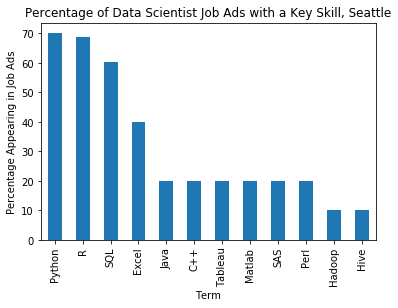

In [21]:
plot_1 = plot(seattle_info, 'Seattle')

         Term  NumPostings
2      Python           87
5           R           75
6         SQL           63
0        Java           25
1       Scala           12
3  JavaScript           12
4     Tableau           12
7         SAS           12
8       Spark           12
9        Ruby           12


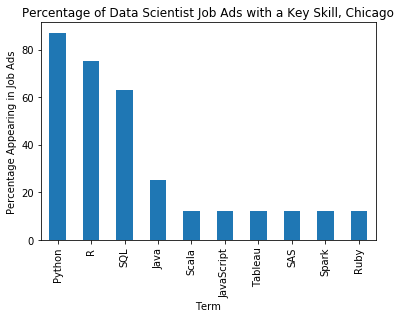

In [15]:
plot_2 = plot(chicago_info, 'Chicago')

In [32]:
def skill_info(city = None, state=None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 2: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[1])*1000) + int(job_numbers[2])
    else:
        total_num_jobs = int(job_numbers[1]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib2.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        #job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        targetElements = soup.findAll('div', attrs={'class':'row'})
        job_URLS = []
        for elem in targetElements:
            home_url = "http://www.indeed.com"
            jobs_link = "%s%s" % (home_url,elem.find('a').attrs['href'])
            job_URLS.append(jobs_link) # Get the URLS for the jobs    
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by = 'NumPostings', ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

/Users/toantran/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/toantran/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


There were 350 jobs found, Seattle
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Done with collecting the job postings!
There were 349 jobs successfully found.


(<Figure size 432x288 with 1 Axes>,        Term  NumPostings
 1    Python    69.914040
 6         R    68.194842
 8       SQL    60.171920
 2     Excel    40.114613
 0      Java    20.057307
 4       C++    20.057307
 5   Tableau    20.057307
 7    Matlab    20.057307
 10     Perl    20.057307
 9       SAS    19.770774
 3    Hadoop    10.028653
 11     Hive    10.028653)

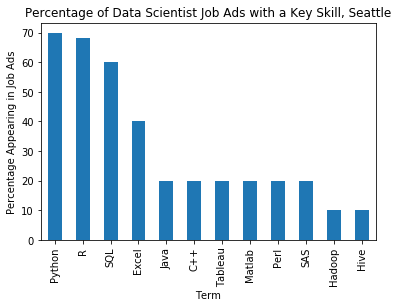

In [10]:
skill_info(city = 'Seattle', state = 'WA')

In [33]:
helsinki_info = skills_info(city='Helsinki')

TypeError: sequence item 5: expected string, NoneType found

In [35]:
silicon_val_info = skills_info(city = 'San Francisco', state = 'CA')

There were 522 jobs found, San Francisco
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Getting page 36
Getting page 37
Getting page 38
Getting page 39
Getting page 40
Getting page 41
Getting page 42
Getting page 43
Getting page 44
Getting page 45
Getting page 46
Getting page 47
Getting page 48
Getting page 49
Getting page 50
Getting page 51
Getting page 52
Done with collecting the job postings!
There were 416 jobs successfully found.


In [ ]:
def skill_info_fi(city = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.fi/jobs?q="', final_job, '"&l=', final_city
                    ] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.fi/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://www.indeed.com'
    
    
    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this
    
    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 2: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[1])*1000) + int(job_numbers[2])
    else:
        total_num_jobs = int(job_numbers[1]) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found
    
    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib2.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        #job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        targetElements = soup.findAll('div', attrs={'class':'row'})
        job_URLS = []
        for elem in targetElements:
            home_url = "http://www.indeed.com"
            jobs_link = "%s%s" % (home_url,elem.find('a').attrs['href'])
            job_URLS.append(jobs_link) # Get the URLS for the jobs    
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
            
        
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'
    
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by = 'NumPostings', ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

In [ ]:
helsinki_info = skill_info_fi(city = 'helsinki')